In [1]:
#IDEAS
#https://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html
#http://sbfnk.github.io/mfiidd/mcmc_diagnostics.html
#https://cran.r-project.org/web/packages/ggmcmc/vignettes/v70i09.pdf

# Advance Statistics for physical analysis project:

# Study of the energy resolution and uncertainties of germanium detectors using bayesian methods


<b>Students</b> : 
   
   - Hilario Capettini
   - João Freitas 
    
<b>Professor</b> :
   
   - Alberto Garfagnini

We have a file containing counts for different channels. These counts were obtained with a Germanium detector irradiated by a combination of three sources $^{241}\text{Am}$, $^{60}\text{Co}$, $^{137}\text{Cs}$. 

Our goal is to characterize the peaks of the signal assigning to them a position $x_i$, a width $w_i$, an amplitude $A_i$ and also to decouple them from the noise characterizing it with an amplitude $B_i$, the subindex $i=1,...,n$ implies that these quantities are specific for each peak in the signal. 

So, given the counts $\{N_k\}$ measured at the values $\{x_k\}$ we want the best estimates for $x_i, \; w_i, \; A_i, \; B_i$ characterizing the noise and the signal peaks. 
In this case we have a photon spectrum were the number of photons was measured by bins of energy. This number is proportional to the exposure $\Delta t$ (the time that we have been measuring) and the other variables that we are considering through the following formula:

$$ S_k = \Delta t \left[A \text{exp}\left(-\frac{(x_k-x_0)^2}{2 w^2}\right)+B\right]  $$

The number of observed photons, $\lambda$, is an integer number and follows the Poisson distribution

$$P(\lambda|S)= \frac{S^\lambda e^{-S}}{\lambda!}$$

as each event is independent from the others, we can obtain the likelihood just by multiplying the Poisson distribution

$$P(D|\theta,M)= \prod_j \frac{S_k^{\lambda_k}e^{-S_k}}{\lambda_k!} $$

were we are using $\theta=(A,B,w,X_0)$

## The whole dataset

In [2]:
library(showtext)
showtext_auto()
library("rjags")
library(BayesianTools)
#https://bookdown.org/steve_midway/BHME/Ch4.html

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

Loading required package: sysfonts
Loading required package: showtextdb
Warning message:
“package ‘rjags’ was built under R version 3.6.3”Loading required package: coda
Warning message:
“package ‘coda’ was built under R version 3.6.3”Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [3]:
r_data <- read.csv("data/IC48A_AmCsCo.txt",header=TRUE, sep="\t")

#Data must be passed in list form
data  <- NULL
data$x <- r_data[[1]]  
data$y <- r_data[[2]]

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1929 y values <= 0 omitted from logarithmic plot”

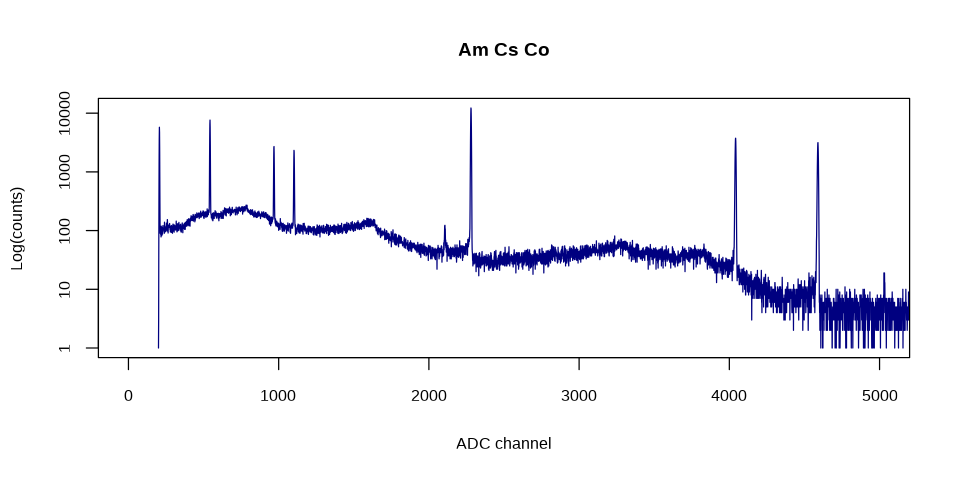

In [4]:
set_plot_dimensions(8, 4)

plot(data$x,data$y,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(0,5000),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")


## One pick analysis 

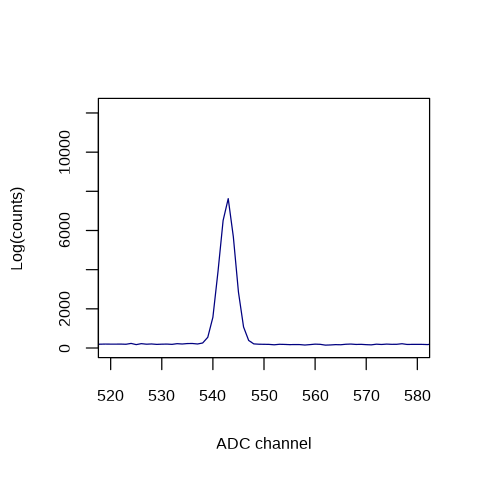

In [5]:
set_plot_dimensions(4, 4)

plot(data$x,data$y, type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(520,580),
    ylab = "Log(counts)", xlab ="ADC channel")

In [6]:
#We reduce the data to the vicinity of the peak
peak_1.data <- NULL
peak_1.data$x <- data$x[530:550] 
peak_1.data$y <- data$y[530:550]

In [7]:
#The model is defined in a .bug (txt) file
#To easily modify the intervals we manage it from the notebook

#The interval for the priors are very importants!

cat("model{

    #The likelihood:

    for (i in 1:length(x)){
        S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)

        y[i] ~ dpois(S[i]) 
    } 


    # Priors for  A, B, x0, w

    A ~ dunif(5000,12000)
    B ~ dunif(0,600)

    x0 ~ dunif(500,600)
    w ~ dunif(1,10)
      
}", file="Models/model_1.bug")

model <- "Models/model_1.bug"

In [8]:
#Define initial values to reduce the search
init <- NULL
init$A  <- 8000
init$B  <- 200
init$w  <- 5
init$x0 <- 545


In [9]:
#Model loading
set.seed(37127874)

jm <- jags.model(model,
                 peak_1.data,
                 inits=init)

#Update the Markov chain (Burn-in)
update(jm, 1000)

chain <- coda.samples(jm, c("A","B","x0","w"), n.iter=1.e4,thin=10)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 21
   Unobserved stochastic nodes: 4
   Total graph size: 203

Initializing model



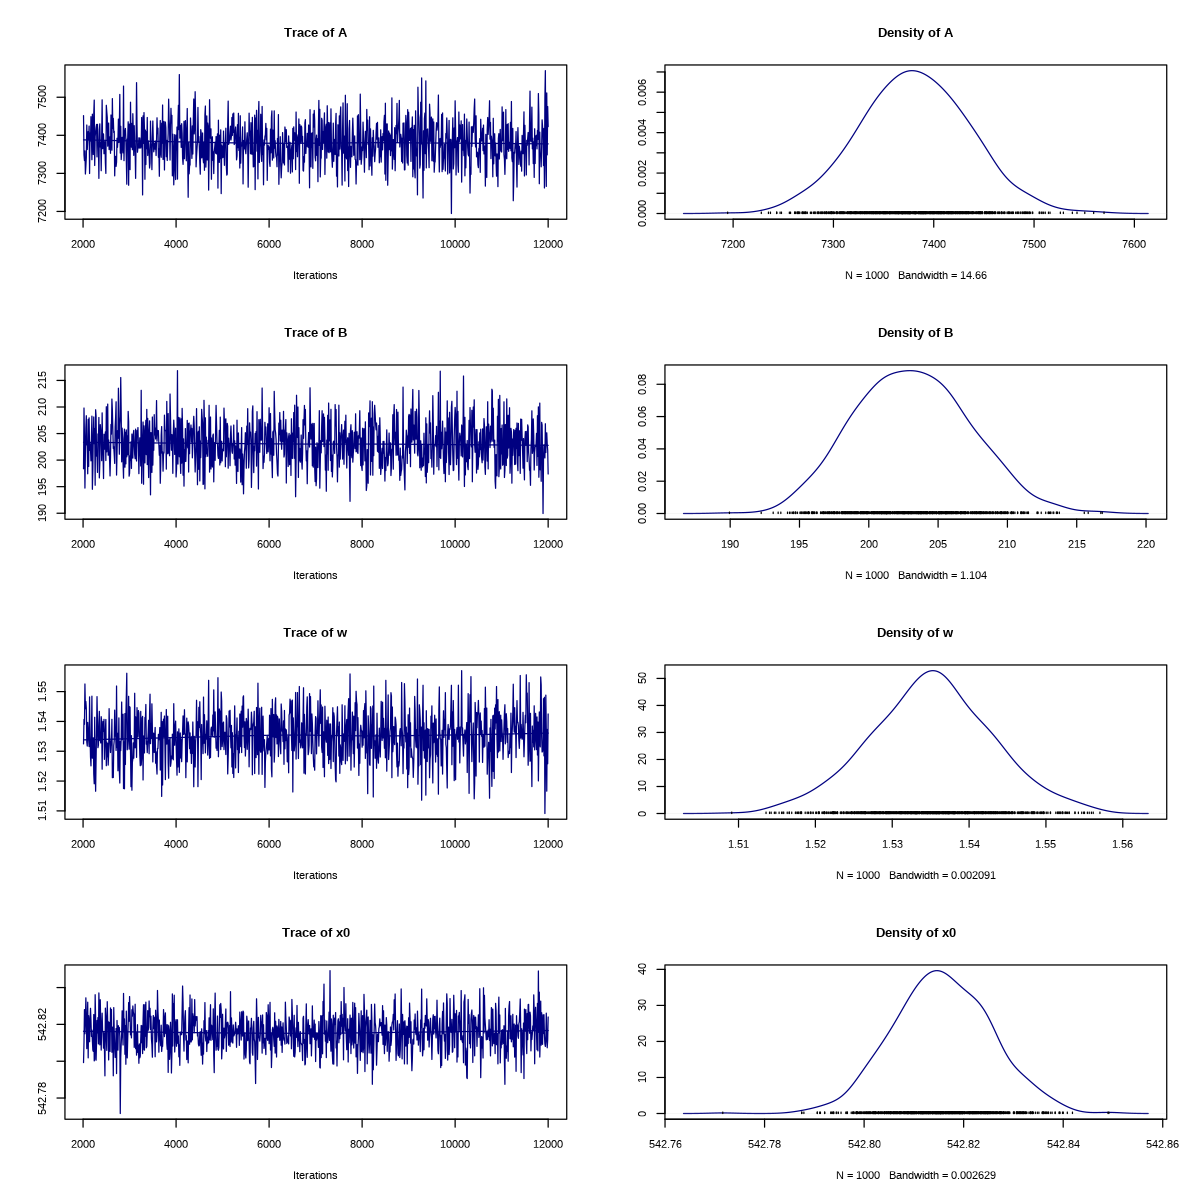

In [10]:
#Generate the chain and posterior plots
options(repr.plot.width = 10, repr.plot.height = 10)
plot(chain, col="navy")

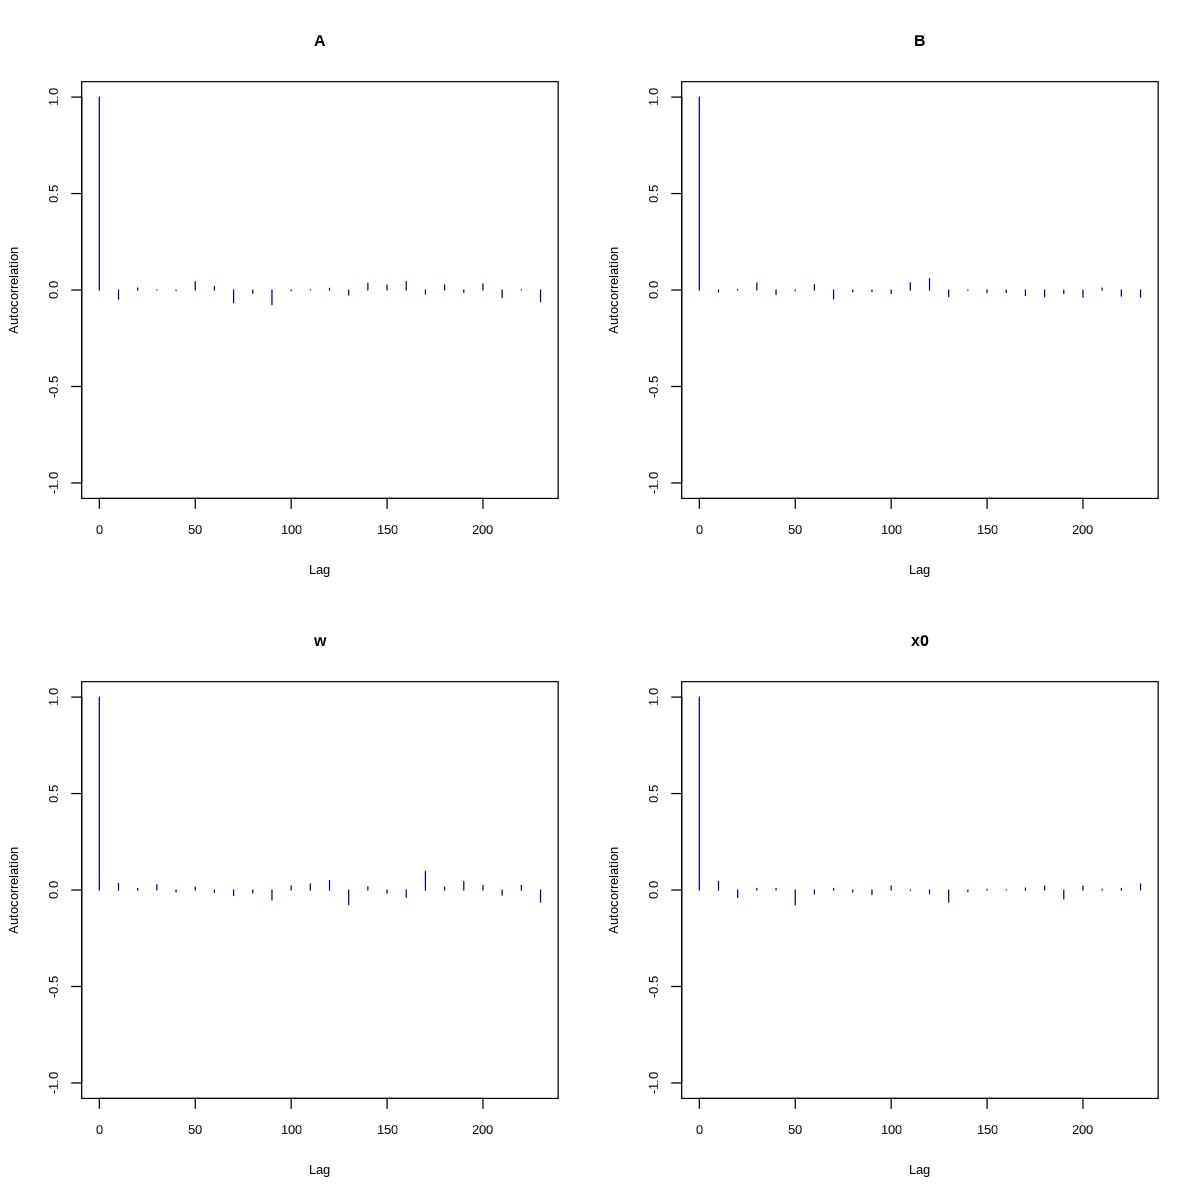

In [11]:
#Autocorrelation plots
autocorr.plot(chain, col='navy')

In [12]:
summary(chain)


Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
A  7381.061 55.063542 1.7412621      1.6608300
B   203.140  4.146097 0.1311111      0.1311111
w     1.535  0.007946 0.0002513      0.0002513
x0  542.816  0.009874 0.0003122      0.0003122

2. Quantiles for each variable:

       2.5%     25%      50%     75%    97.5%
A  7271.249 7343.65 7380.885 7417.95 7491.506
B   195.487  200.23  203.034  205.92  211.207
w     1.519    1.53    1.535    1.54    1.552
x0  542.798  542.81  542.815  542.82  542.836


In [13]:
A  <- summary(chain)$statistics[1]
B  <- summary(chain)$statistics[2]
w  <- summary(chain)$statistics[3]
x0  <- summary(chain)$statistics[4]
x <- seq(530,570,0.25)
f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)

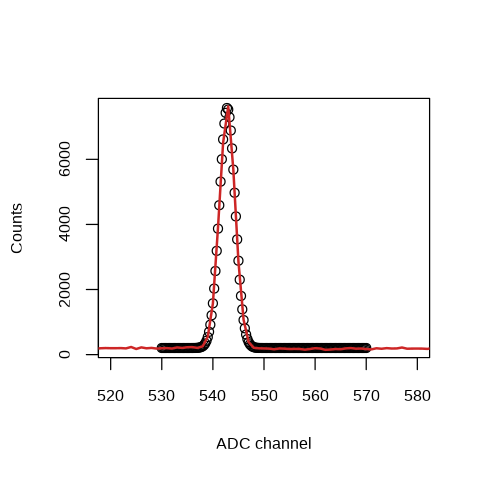

In [14]:
set_plot_dimensions(4, 4)

plot(x,f, xlim=c(520,580),
    ylab = "Counts", xlab ="ADC channel")
lines(data$x,data$y, lwd=2, col='firebrick3')

### Correlations

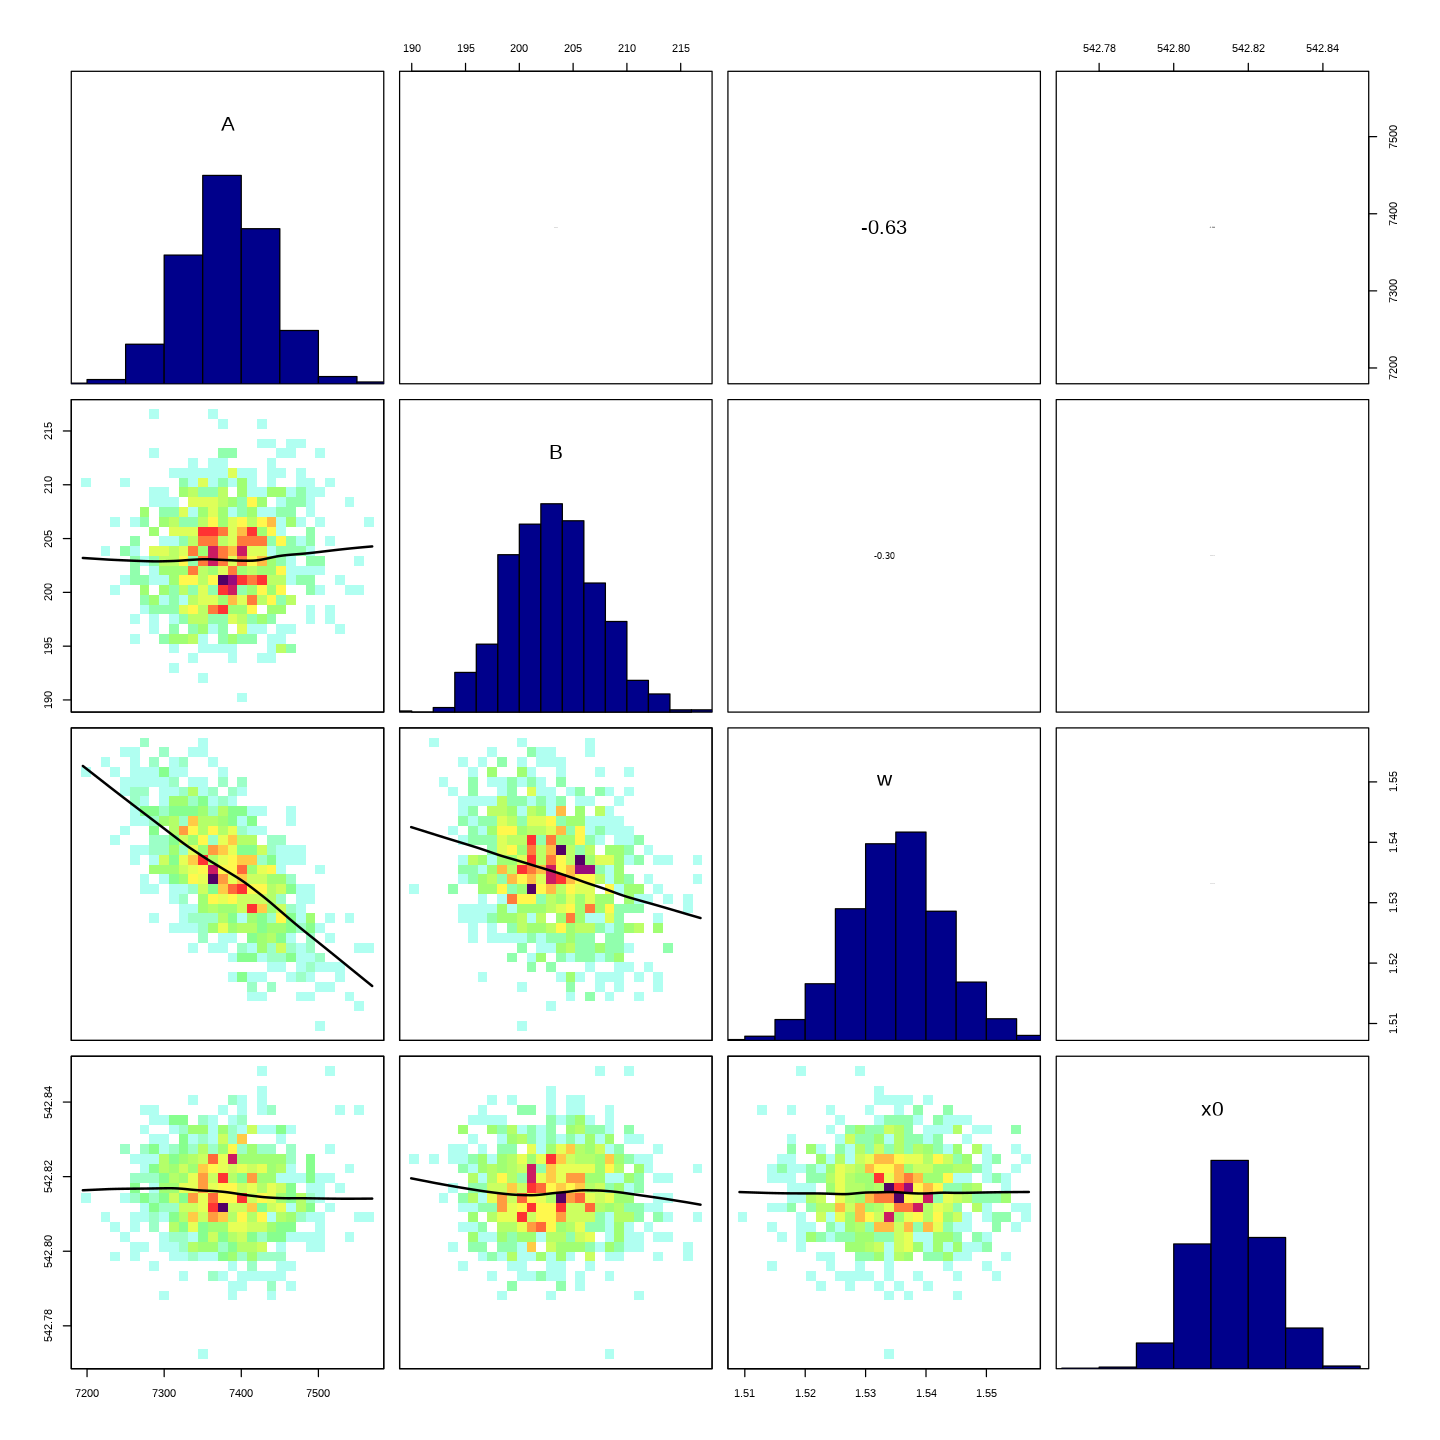

In [15]:
set_plot_dimensions(12, 12)
correlationPlot((chain))

### Convergence

In [54]:
#If multiple chains are run, each of them need to be initialized
init_1 <- NULL;init_1$A  <- 8000; init_1$B  <- 0; init_1$w  <- 5; init_1$x0 <- 545
init_2 <- NULL;init_2$A  <- 9000; init_2$B  <- 100; init_2$w  <- 5; init_2$x0 <- 545
init_3 <- NULL;init_3$A  <- 10000; init_3$B  <- 200; init_3$w  <- 5; init_3$x0 <- 545

#To have absolute control we also set the seed for and random number generator for each chain
init <- list(c(init_1,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init_2,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init_3,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"))

In [55]:
jm2 <- jags.model(model,
                 peak_1.data,
                 inits=init,
                 n.chains=3)

#Update the Markov chain (Burn-in)
update(jm2, 1000)

chain2 <- coda.samples(jm2, c("A","B","w","x0"), n.iter=1.e4,thin=10)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 21
   Unobserved stochastic nodes: 4
   Total graph size: 203

Initializing model



Potential scale reduction factors:

   Point est. Upper C.I.
A           1       1.01
B           1       1.00
w           1       1.01
x0          1       1.01

Multivariate psrf

1

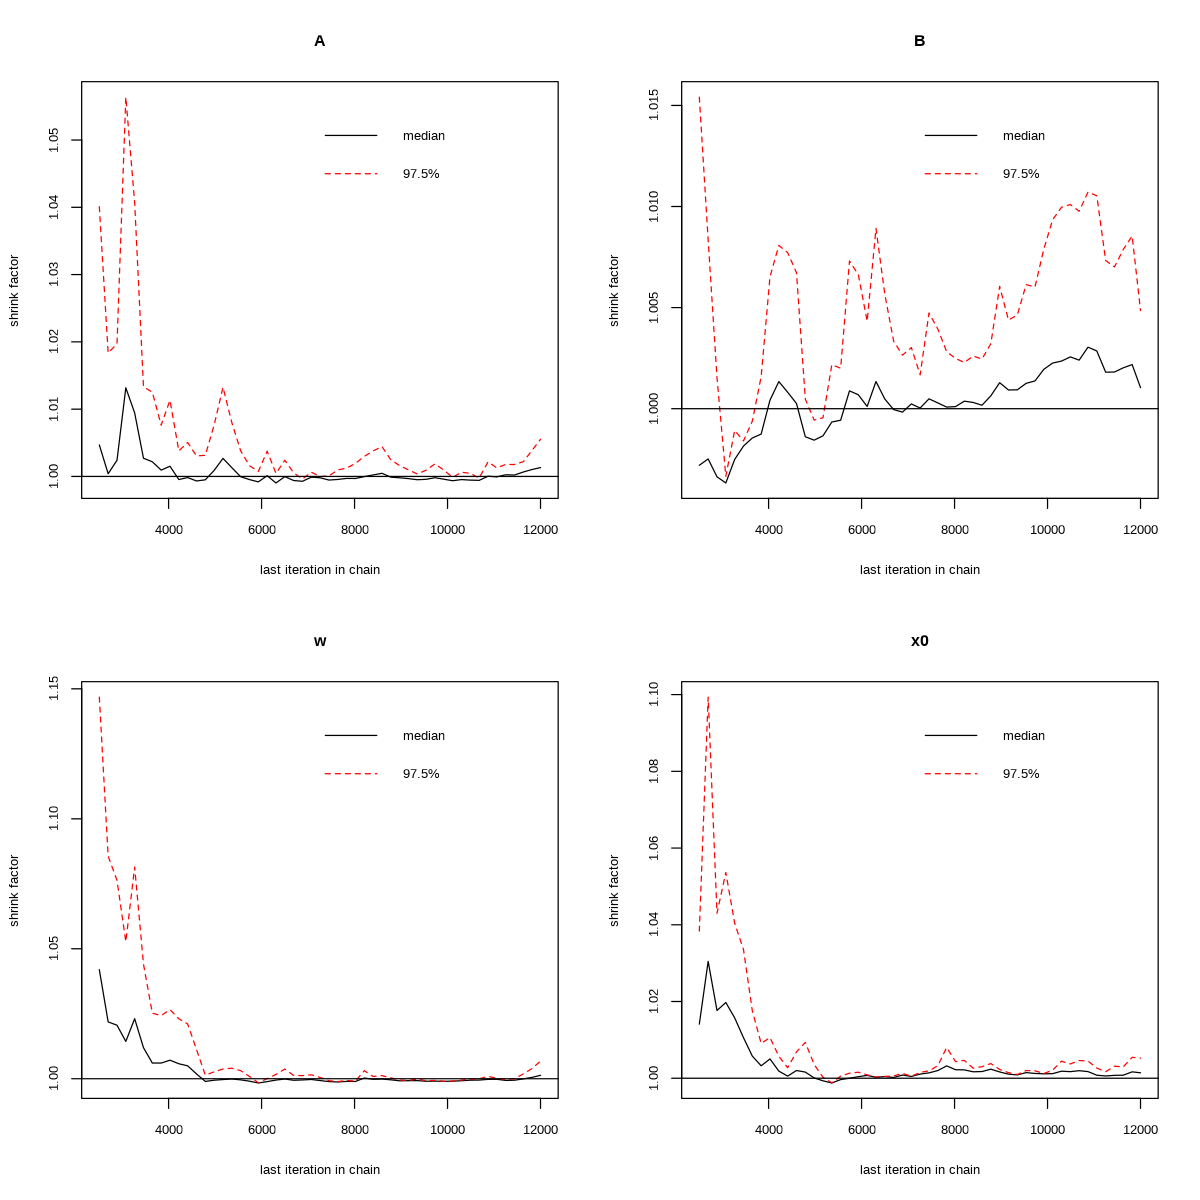

In [56]:
gelman.diag(chain2)
gelman.plot(chain2)

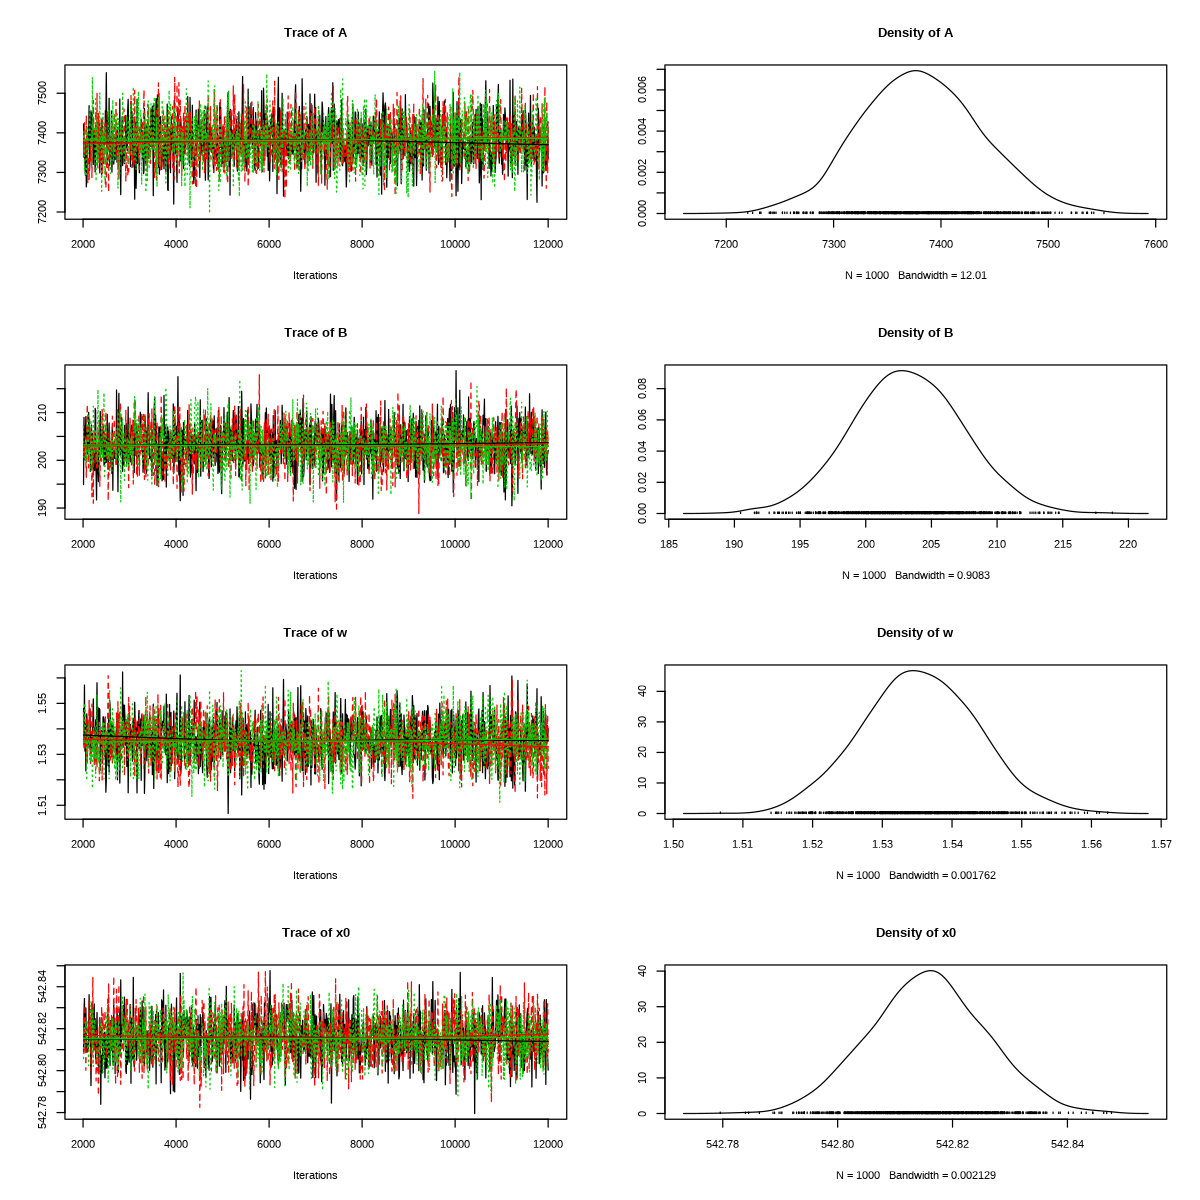

In [57]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot(chain2)

In [58]:
#chain2[[1]][,"A"]